# PIC-SURE API use-case: Phenome-Wide analysis on BioDataCatalyst data

This is a tutorial notebook, aimed to be quickly up and running with the R PIC-SURE API. It covers the main functionalities of the API.

## PIC-SURE R API 
### What is PIC-SURE? 

<!--img src="./img/PIC-SURE_logo.png" width= "360px"> -->

Databases exposed through PIC-SURE API encompass a wide heterogeneity of architectures and data organizations underneath. PIC-SURE hide this complexity and expose the different databases in the same format, allowing researchers to focus on the analysis and medical insights, thus easing the process of reproducible sciences.

### More about PIC-SURE
PIC-SURE stands for Patient-centered Information Commons: Standardized Unification of Research Elements. The API is available in two different programming languages, python and R, allowing investigators to query databases in the same way using any of those languages.

PIC-SURE is a large project from which the R/python PIC-SURE API is only a brick. Among other things, PIC-SURE also offers a graphical user interface, allowing research scientist to get quick knowledge about variables and data available for a specific data source.

The python API is actively developed by the Avillach-Lab at Harvard Medical School.

GitHub repo:
* https://github.com/hms-dbmi/pic-sure-python-adapter-hpds
* https://github.com/hms-dbmi/pic-sure-python-client



 -------   

# Getting your own user-specific security token

**Before running this notebook, please be sure to review the get_your_token.ipynb notebook. It contains explanation about how to get a security token, mandatory to access the databases.**

# Environment set-up

### Pre-requisite
- R 3.5 or later

### Packages installation

In [1]:
list_packages <- c("ggrepel",
                   "jsonlite", 
                   "ggplot2",
                   "plyr",
                   "dplyr",
                   "tidyr",
                   "purrr",
                   "devtools")

for (package in list_packages){
     if(! package %in% installed.packages()){
         install.packages(package, dependencies = TRUE)
     }
     library(package, character.only = TRUE)
}

Loading required package: ggplot2


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The following object is masked from ‘package:jsonlite’:

    flatten


Loading required package: usethis



#### Installing latest R PIC-SURE API libraries from github

In [2]:
devtools::install_github("hms-dbmi/pic-sure-r-client", force=T)
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds", force=T)


✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpyeaETE/remotesc80f2c310e37/hms-dbmi-pic-sure-r-client-d62fec5/DESCRIPTION’ (509ms)
─  preparing ‘picsure’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘picsure_0.1.0.tar.gz’
   



✔  checking for file ‘/private/var/folders/hm/wn0bpy0j7vl2q9gqnhhccpph0000gn/T/RtmpyeaETE/remotesc80f6709edd1/hms-dbmi-pic-sure-r-adapter-hpds-353b541/DESCRIPTION’
─  preparing ‘hpds’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘hpds_0.1.0.tar.gz’
   


##### Loading user-defined functions

In [3]:
source("R_lib/utils.R")

## Connecting to a PIC-SURE network

Several information are needed to get access to data through the PIC-SURE API: a network URL, a resource id, and a user security token which is specific to a given URL + resource.

In [4]:
PICSURE_network_URL <- "https://biodatacatalyst.integration.hms.harvard.edu/picsure"
resource_id <- "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file = "token.txt"

In [5]:
my_token <- scan(token_file, what = "character")

In [6]:
connection <- picsure::connect(url = PICSURE_network_URL,
                                 token = my_token)

In [7]:
resource <- hpds::get.resource(connection,
                               resourceUUID = resource_id)

Two objects are created here: a `connection` and a `resource` object, using respectively the `picsure` and `hpds` libraries. 

As we will only be using one single resource, **the `resource` object is actually the only one we will need to proceed with data analysis hereafter** (FYI, the `connection` object is useful to get access to different databases stored in different resources). 

It is connected to the specific data source ID we specified, and enables to query and retrieve data from this source.

## Getting help with the R PIC-SURE API

The `?` operator prints out helper message for any PIC-SURE library function.

In [8]:
?hpds::get.resource()

get.resource {hpds},R Documentation
connection,A PIC-SURE connection object.
resourceUUID,The UUID identity of a Resource hosted via the PIC-SURE connection.
verbose,Flag to display additional runtime information.


## Using the *variables dictionnary*

Once a connection to the desired resource has been established, we first need to get a quick idea of which variables are available in the database. To this end, we will use the `dictionary` method of the `resource` object.

A `dictionary` instance offers the possibility to retrieve matching records according to a specific term, or to retrieve information about all available variables, using the `find.in.dictionary()` function. For instance, looking for variables containing the term `COPD` is done this way: 

In [9]:
dictionary_search <- hpds::find.in.dictionary(resource, "COPD")

Subsequently, objects created by the `dictionary.find` exposes the search result using 4 different methods: `.count()`, `.keys()`, `.entries()`, and `.DataFrame()`. 

In [10]:
print(list("Count"   = hpds::extract.count(dictionary_search), 
           "Keys"    = hpds::extract.keys(dictionary_search)[1:3],
           "Entries" = hpds::extract.entries(dictionary_search)[1:3]))

$Count
[1] 425

$Keys
[1] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\CT Acquisition Parameters\\CT Slicer\\Percent gas trapping total lung: CT Slicer\\"                                             
[2] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\Respiratory Disease\\Family History\\Asthma: Father or Mother\\Father: asthma\\"                                                
[3] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\Respiratory Disease\\Respiratory Conditions\\Hayfever\\Hayfever: diagnosed by doctor or other health professional\\"            
[4] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\Respiratory Disease\\Educational and Occupational History\\Work/ Education\\Highest degree or level of school completed\\"      
[5] "\\Genetic Epidemiology of COPD (COPDGene)\\Subject Phenotype\\Respiratory Disease\\Respiratory Conditions\\Hayfever\\Hayfever: have you ever had hay fever (allergy involving nose or eyes)\\

In [11]:
df_dictionary_copd <- hpds::extract.dataframe(dictionary_search) 

**`hpds::extract.dataframe()` enables to get the result of the dictionary search in a data.frame format. This way, it enables to:** 

* Use the various criteria exposed in the dictionary (patientCount, variable type ...) as criteria for variable selection.
* Use the row names of the DataFrame to get the actual variables names, to be used in the query, as shown below.

Variable names, as currently implemented in the API, aren't handy to use right away.
1. Very long
2. Presence of backslashes that requires modification right after copy-pasting. 

However, using the dictionary to select variables can help to deal with this. Let's say we want to retrieve every variable from the COPDGene study. Hence, one way to proceed is to retrieve the whole dictionary for those variables in the form of a data.frame, as below:

In [12]:
plain_variablesDict <- hpds::find.in.dictionary(resource, "COPDGene") %>% hpds::extract.dataframe()

Moreover, using the `hpds::find.in.dictionary` function without arguments return every entries, as shown in the help documentation. *As for now, this takes a long time in the R PIC-SURE API implementation, and it will probably be fixed in the latter version of the API*

In [13]:
plain_variablesDict[10:20,]

,name,min,categorical,observationCount,patientCount,max,HpdsDataType,categoryValues
,<chr>,<dbl>,<lgl>,<int>,<int>,<dbl>,<chr>,<chr>
10,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Cardio Vascular Diseases\Heart attack [MI]\,NA,TRUE,10099,10099,NA,phenotypes,"No,Yes"
11,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Respiratory Symptoms\Shortness of Breath\Too breathless to leave the house on dressing/undressing\,NA,TRUE,6418,6418,NA,phenotypes,"Does not apply,No,Yes"
12,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\SF-36 Health Survey\SF-36 General Health (GH) t-score (normalized)\,16.23,FALSE,4573,4573,63.9,phenotypes,NA
13,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Respiratory Conditions\Asthma\Asthma: have you ever had asthma\,NA,TRUE,10099,10099,NA,phenotypes,"Do not know,No,Yes"
14,\Genetic Epidemiology of COPD (COPDGene)\Subjects\Consent group as determined by DAC\,NA,TRUE,10383,10383,NA,phenotypes,"Disease-Specific (COPD and Smoking) (DS-CS),Health/Medical/Biomedical (HMB),Subjects did not participate in the study, did not complete a consent document and are included only for the pedigree structure and/or genotype controls, such as HapMap subjects"
15,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Environmental Exposures\Cigarette Smoking\How old were you when you completely stopped smoking? [Years old]\,4.00,FALSE,4799,4799,79.0,phenotypes,NA
16,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\COPD Exacerbations in the Last Year\Lung Problems\How many times\,0.00,FALSE,1169,1169,35.0,phenotypes,NA
17,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Walk symptoms: leg discomfort/fatigue\,NA,TRUE,3688,3688,NA,phenotypes,"Checked (multiple-response),No"
18,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Sociodemography and Administration\Race Adjusted\De-identified site code\,NA,TRUE,10371,10371,NA,phenotypes,"C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21"


The dictionary currently returned by the API provide various information about the variables, such as:
- observationCount: number of entries with non-null value
- categorical: type of the variables, True if categorical, False if continuous/numerical
- min/max: only provided for non-categorical variables
- HpdsDataType: 'phenotypes' or 'genotypes'. Currently, the API only expsoses'phenotypes' variables

### Parsing variable names

Though helpful, we can use a simple function, `get_multiIndex_variablesDict`, defined in `R_lib/utils.R` to add a little more information and ease working with variables names. 

Although not an official feature of the API, such functionality illustrate how to quickly scan an select groups of related variables.

Printing part of the "parsed names" Dictionary allows to quickly see the tree-like organisation of the variables. Moreover, original and simplified variable names are now stored respectively in the "varName" and "simplified_varName" columns (simplified variable names is simply the last component of the variable name, which usually makes the most sense to know what each variable is about).

In [14]:
# Display the variables tree hierarchy from the variables name
variablesDict <- get_multiIndex_variablesDict(plain_variablesDict)
head(variablesDict)

level_0,level_1,level_2,level_3,level_4,level_5,simplified_name,name,observationCount,categorical,categoryValues,nb_modalities,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<chr>
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,CT Acquisition Parameters,CT Slicer,Percent gas trapping total lung: CT Slicer,NA,Percent gas trapping total lung: CT Slicer,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\CT Acquisition Parameters\CT Slicer\Percent gas trapping total lung: CT Slicer\,8276,FALSE,NA,1,0.0214,87.8387,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Respiratory Disease,Environmental Exposures,Second-hand Smoke Exposure,How many years exposed to smoke at work [years],How many years exposed to smoke at work [years],\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Environmental Exposures\Second-hand Smoke Exposure\How many years exposed to smoke at work [years]\,10097,FALSE,NA,1,0.0000,80.0000,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Respiratory Disease,Family History,Asthma: Father or Mother,Father: asthma,Father: asthma,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Family History\Asthma: Father or Mother\Father: asthma\,10098,TRUE,"Do not know,No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Respiratory Disease,Respiratory Conditions,Hayfever,Hayfever: diagnosed by doctor or other health professional,Hayfever: diagnosed by doctor or other health professional,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Respiratory Conditions\Hayfever\Hayfever: diagnosed by doctor or other health professional\,3000,TRUE,"Do not know,No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Respiratory Disease,Environmental Exposures,Cigar Smoking,Have you ever smoked cigars regularly?,Have you ever smoked cigars regularly?,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Respiratory Disease\Environmental Exposures\Cigar Smoking\Have you ever smoked cigars regularly?\,10098,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,6MinWalk,Six minute walk: course layout,NA,NA,Six minute walk: course layout,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\6MinWalk\Six minute walk: course layout\,10090,TRUE,"Circular,Straight",NA,NA,NA,phenotypes


Below is a simple example to illustrate the ease of use a parsed dictionary. Let's say we are interested in every variables pertaining to the "Medical history" and "Medication history" subcategories.

In [15]:
mask_medication <- variablesDict[,3] == "Medication History"
mask_medical <- variablesDict[,3] == "Medical History"
medication_history_variables <- variablesDict[mask_medical | mask_medication,]
medication_history_variables

level_0,level_1,level_2,level_3,level_4,level_5,simplified_name,name,observationCount,categorical,categoryValues,nb_modalities,min,max,HpdsDataType
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<lgl>,<chr>,<int>,<dbl>,<dbl>,<chr>
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Cardio Vascular Diseases,Heart attack [MI],NA,Heart attack [MI],\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Cardio Vascular Diseases\Heart attack [MI]\,10099,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medication History,Treatment,Ipratropium bromide,NA,Ipratropium bromide,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medication History\Treatment\Ipratropium bromide\,9881,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Cancer,Lung cancer,NA,Lung cancer,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Cancer\Lung cancer\,10097,TRUE,No,NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Cancer,Prostate cancer,NA,Prostate cancer,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Cancer\Prostate cancer\,10098,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medication History,Treatment,Tiotroprium bromide,NA,Tiotroprium bromide,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medication History\Treatment\Tiotroprium bromide\,9910,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Digestive System Diseases,Gastroesophageal reflux,NA,Gastroesophageal reflux,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Digestive System Diseases\Gastroesophageal reflux\,10098,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Painful Joint Type,Painful joint type: knee,NA,Painful joint type: knee,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Painful Joint Type\Painful joint type: knee\,2217,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Musculoskeletal Diseases,Stiffness/pain in joints/bones limit ability to walk,NA,Stiffness/pain in joints/bones limit ability to walk,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Musculoskeletal Diseases\Stiffness/pain in joints/bones limit ability to walk\,10099,TRUE,"No,Yes",NA,NA,NA,phenotypes
Genetic Epidemiology of COPD (COPDGene),Subject Phenotype,Medical History,Painful Joint Type,Painful joint type: wrist or hand,NA,Painful joint type: wrist or hand,\Genetic Epidemiology of COPD (COPDGene)\Subject Phenotype\Medical History\Painful Joint Type\Painful joint type: wrist or hand\,2217,TRUE,"No,Yes",NA,NA,NA,phenotypes


Although pretty simple, it can be easily combined with other filters to quickly select necessary variables.

## Querying and retrieving data

Beside from the dictionary, the second cornerstone of the API are the `query` functions (`hpds::query.anyof`, `hpds::query.select`, `hpds::query.filter`, `hpds::query.require`). They are the entering point to retrieve data from the resource.

First, we need to create a query object.

In [16]:
my_query <- hpds::new.query(resource = resource)

The query object created will be then be passed to the different query functions to build the query: `hpds::query.anyof`, `hpds::query.select`, `hpds::query.filter`, `hpds::query.require`. Each of those methods accept a query object, a list of variable names, and eventual additional parameters

- The `query.select.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, without any record (ie subjects/rows) subsetting.

- The `query.require.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all the variables passed, and only records that do not contain any null values for those variables.

- The `query.anyof.add()` method accept variable names as string or list of strings as argument, and will allow the query to return all variables included in the list, and only records that do contain at least one non-null value for those variables.

- The `query.filter.add()` method accept variable names a variable name as strings as argument, plus additional values to filter on that given variable. The query will return this variable and only the records that do match this filter.

All those 4 methods can be combined when building a query. The record eventually returned by the query have to meet all the different specified filters.

#### Building the query

In [17]:
mask <- variablesDict["simplified_name"] == "How old were you when you completely stopped smoking? [Years old]"
yo_stop_smoking_varname <- variablesDict[mask, "name"] %>%unlist() %>% unname()

In [18]:
mask_cat <- plain_variablesDict["categorical"] == TRUE
mask_count <- plain_variablesDict["observationCount"] > 4000
selected_vars <- plain_variablesDict[mask_cat & mask_count, "name"] %>% as.list()

In [19]:
hpds::query.filter.add(query = my_query, 
                      keys = yo_stop_smoking_varname, 
                      min=20, 
                      max=70)
hpds::query.select.add(query = my_query, 
                      keys = selected_vars[1:50])

## Retrieving the data

Once our query object is finally built, we use the `query.run` function to retrieve the data corresponding to our query

In [20]:
my_df <- hpds::query.run(my_query, result.type = "dataframe")

In [21]:
dim(my_df)

[1] 4678   52

In [22]:
head(my_df)

Patient.ID,X.Genetic.Epidemiology.of.COPD..COPDGene..Samples.Study.,X.Genetic.Epidemiology.of.COPD..COPDGene..Samples.Subject.ID.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.6MinWalk.Six.minute.walk..course.layout.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.CT.Acquisition.Parameters.CT.Scanner.CT.scan.final.approval.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.CT.Assessment.Scoresheet.High.Concerns.QA_CalciumCalPad.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Demographics.and.Physical.Characteristics.Demographics.Gender.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Medical.History.Cancer.Lung.cancer.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Medical.History.Cancer.Prostate.cancer.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Medical.History.Cardio.Vascular.Diseases.Heart.attack..MI..,⋯,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Conditions.Pneumonia.or.Bronchopneumonia.Pneumonia..have.you.ever.had.pneumonia.or.bronchopneumonia.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Conditions.Sleep.Apnea.Sleep.apnea..have.you.ever.had.sleep.apnea.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Symptoms.Cough.Do.you.usually.have.a.cough..exclude.clearing.of.throat..,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Symptoms.Shortness.of.Breath.Too.breathless.to.leave.the.house.on.dressing.undressing.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Symptoms.Sneezing.Sneezing.runny.blocked.nose.when.you.did.not.have.a.cold.flu.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Symptoms.Wheezing.or.Whistling.in.Chest.Had.an.attack.of.wheezing.whistling.in.chest.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Respiratory.Symptoms.Wheezing.or.Whistling.in.Chest.Wheezing..most.days.and.nights.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Respiratory.Disease.Severity.of.COPD.Exacerbations.Chest.Trouble.Been.treated.with.steroid.pills.or.injections.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subject.Phenotype.Sociodemography.and.Administration.Race.Adjusted.De.identified.site.code.,X.Genetic.Epidemiology.of.COPD..COPDGene..Subjects.Consent.group.as.determined.by.DAC.
<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
35464,,,Straight,Yes,No,Male,No,No,No,⋯,No,No,No,,No,No,,No,C06,Health/Medical/Biomedical (HMB)
35466,null,COPDGene_A01133,Straight,Yes,No,Female,No,No,No,⋯,Yes,No,No,,Yes,Yes,,No,C07,Health/Medical/Biomedical (HMB)
35467,null,COPDGene_A01220,Straight,No,Yes,Female,No,No,No,⋯,Yes,No,Yes,No,Yes,Yes,No,Yes,C07,Health/Medical/Biomedical (HMB)
35473,null,COPDGene_A03795,Straight,Yes,No,Male,No,No,No,⋯,Yes,No,No,,No,No,No,No,C02,Health/Medical/Biomedical (HMB)
35477,null,COPDGene_A05113,Straight,Yes,Yes,Male,No,No,No,⋯,Yes,Do not know,Yes,Yes,Yes,Yes,Yes,Yes,C03,Health/Medical/Biomedical (HMB)
35479,null,COPDGene_A05779,Straight,Yes,Yes,Male,No,No,No,⋯,Do not know,Do not know,Yes,Yes,Yes,Yes,Yes,Yes,C09,Health/Medical/Biomedical (HMB)


From this point, we can proceed with the data management and analysis using any other R function or libraries.

In [23]:
parsed <- parsing_varNames(yo_stop_smoking_varname)

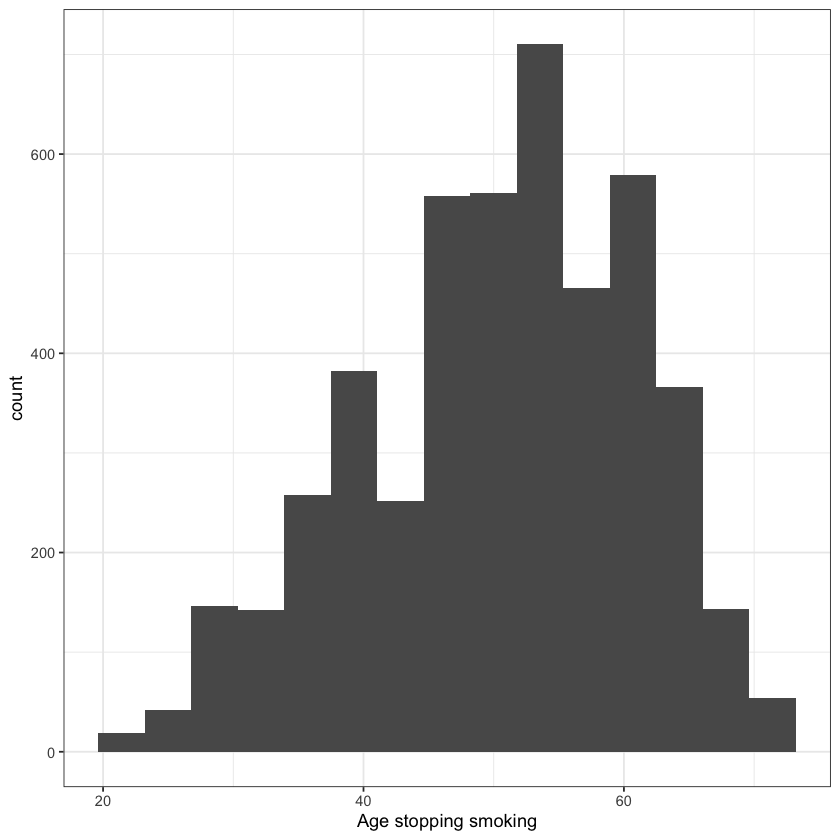

In [37]:
ggplot(my_df) + geom_histogram(aes_string(x=parsed), bins=15) +
labs(x="Age stopping smoking", y= "count") +
theme_bw()